# Active Learning
Active learning is an iterative process where a model actively selects the most informative data points to be labeled by an oracle (e.g. a human expert), optimizing the model's performance with fewer labeled samples. Active learning can be implemented with Chemprop through Python as demonstrated by this notebook.

# Import Packages

In [1]:
import random
from typing import Tuple

from lightning import pytorch as pl
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch
from torch.utils.data import DataLoader

from chemprop import data, featurizers, models, nn

# Change data inputs

In [2]:
chemprop_dir = Path.cwd().parent
input_path = chemprop_dir / "tests" / "data" / "regression" / "mol" / "mol.csv" # path to your data .csv file
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = 'smiles' # name of the column containing SMILES strings
target_columns = ['lipo'] # list of names of the columns containing targets

## Load data

In [3]:
df_input = pd.read_csv(input_path)
df_input

,smiles,lipo
0,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,3.54
1,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,-1.18
2,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,3.69
3,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,3.37
4,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,3.10
...,...,...
95,CC(C)N(CCCNC(=O)Nc1ccc(cc1)C(C)(C)C)C[C@H]2O[C...,2.20
96,CCN(CC)CCCCNc1ncc2CN(C(=O)N(Cc3cccc(NC(=O)C=C)...,2.04
97,CCSc1c(Cc2ccccc2C(F)(F)F)sc3N(CC(C)C)C(=O)N(C)...,4.49
98,COc1ccc(Cc2c(N)n[nH]c2N)cc1,0.20


## Get SMILES and targets

In [4]:
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns].values

In [5]:
smis[:5] # show first 5 SMILES strings

array(['Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14',
       'COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23',
       'COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl',
       'OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3',
       'Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)NCC#N)c1'],
      dtype=object)

In [6]:
ys[:5] # show first 5 targets

array([[ 3.54],
       [-1.18],
       [ 3.69],
       [ 3.37],
       [ 3.1 ]])

## Get molecule datapoints

In [7]:
all_data = [data.MoleculeDatapoint.from_smi(smi, y) for smi, y in zip(smis, ys)]

## Data splitting for training/validation pool and testing

In [8]:
# available split types
list(data.SplitType.keys())

['CV_NO_VAL',
 'CV',
 'SCAFFOLD_BALANCED',
 'RANDOM_WITH_REPEATED_SMILES',
 'RANDOM',
 'KENNARD_STONE',
 'KMEANS']

In [9]:
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
nontest_indices, _, test_indices = data.make_split_indices(mols, "random", (0.9, 0.0, 0.1))
nontest_data, _, test_data = data.split_data_by_indices(
    all_data, nontest_indices, None, test_indices
)

## Get featurizer

In [10]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

## Get scaler

In [11]:
nontest_dset = data.MoleculeDataset(nontest_data, featurizer)
scaler = nontest_dset.normalize_targets()

## Batch norm

In [12]:
batch_norm = False

# Change model inputs here

In [13]:
def get_mpnn():
    output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
    ffn = nn.MveFFN(output_transform=output_transform)

    metric_list = [nn.metrics.RMSEMetric(), nn.metrics.MAEMetric()]
    mpnn = models.MPNN(nn.BondMessagePassing(), nn.MeanAggregation(), ffn, batch_norm, metric_list)

    return mpnn

get_mpnn()

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): Identity()
  (predictor): MveFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=2, bias=True)
      )
    )
    (criterion): MVELoss(task_weights=[[1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
)

## Getting dataloaders

In [14]:
def get_dataloaders(trainval_data) -> Tuple[DataLoader]:
    trainval_mols = [d.mol for d in trainval_data]  # RDkit Mol objects are use for structure based splits
    train_indices, _, val_indices = data.make_split_indices(trainval_mols, "random", (0.9, 0.0, 0.1))
    train_data, val_data, _ = data.split_data_by_indices(
        trainval_data, train_indices, val_indices, None
    )

    train_dset = data.MoleculeDataset(train_data, featurizer)
    train_dset.normalize_targets(scaler)

    val_dset = data.MoleculeDataset(val_data, featurizer)
    val_dset.normalize_targets(scaler)

    test_dset = data.MoleculeDataset(test_data, featurizer)

    train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
    val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
    test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)
    return train_loader, val_loader, test_loader

## Set up trainer

In [15]:
trainer = pl.Trainer(logger=False, enable_progress_bar=False, accelerator="cpu", devices=1, max_epochs=20)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


# Change active learning parameters here

A priority function (or acquistition function) guides the active learning process by selecting the most informative data points to label next. A good choice for such a function is the uncertainty of a model's output on each data point.

In [16]:
# rank datapoint based on priority, priority determined by variance
def priority_function(mpnn, mol):
    dataset = data.MoleculeDataset([mol], featurizer)
    loader = data.build_dataloader(dataset, num_workers=num_workers)
    output = trainer.predict(mpnn, loader)
    output = torch.concat(output, dim=0)
    return output[...,1]

# Train with active learning

In [17]:
# the oracle takes a list of potentially unlabeled datapoints to be labeled for the next active learning iteration.
def request_labels(new_data):
    pass

    # adding new data labels:
    
    # for datapoint in new_data:
    #     datapoint.y = {label}

## Start training

In [18]:
query_size = len(nontest_data) // 8  # number of new datapoints added to trainval pool each iteration.

train_sizes = list(range(query_size, len(nontest_data) + 1, query_size))  # size of trainval datapool for each interval.
train_sizes[-1] = len(nontest_data)  # include all data in last iteration.

In [19]:
trainval_data = []
remaining_data = nontest_data
al_results = []

mpnn = get_mpnn()
for train_size in train_sizes:
    # sort new datapoints by priority using priority function
    priority_remaining_data = [(priority_function(mpnn, d), d) for d in remaining_data]
    sorted_remaining_data = [d[1] for d in sorted(priority_remaining_data, reverse=True)] 
    new_size = query_size

    new_data = sorted_remaining_data[:new_size]
    remaining_data = remaining_data[new_size:]

    request_labels(new_data)
    trainval_data.extend(new_data)

    train_loader, val_loader, test_loader = get_dataloaders(trainval_data)

    mpnn = get_mpnn()  # remove this line to continue training from the previous model
    trainer.fit(mpnn, train_loader, val_loader)
    
    result = trainer.test(mpnn, test_loader)  # intermediate results can be used for early stopping
    al_results.append((train_size, result[0]['batch_averaged_test/rmse']))

/Users/brianli/Documents/chemprop/chemprop/data/dataloader.py:52: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.90, got 0.82. Requested test siz

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  batch_averaged_test/mae  │     1.065584421157837     │
│ batch_averaged_test/rmse  │    1.3354130983352661     │
└───────────────────────────┴───────────────────────────┘

/Users/brianli/Documents/chemprop/chemprop/data/dataloader.py:52: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.90, got 0.86. Requested test siz

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  batch_averaged_test/mae  │     0.698561429977417     │
│ batch_averaged_test/rmse  │    0.9729401469230652     │
└───────────────────────────┴───────────────────────────┘

/Users/brianli/Documents/chemprop/chemprop/data/dataloader.py:52: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.90, got 0.88. Requested test siz

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  batch_averaged_test/mae  │    0.6967717409133911     │
│ batch_averaged_test/rmse  │    0.9726821780204773     │
└───────────────────────────┴───────────────────────────┘

/Users/brianli/Documents/chemprop/chemprop/data/dataloader.py:52: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.90, got 0.89. Requested test siz

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  batch_averaged_test/mae  │    0.7074605226516724     │
│ batch_averaged_test/rmse  │    0.9814139604568481     │
└───────────────────────────┴───────────────────────────┘

/Users/brianli/Documents/chemprop/chemprop/data/dataloader.py:52: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.90, got 0.89. Requested test siz

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  batch_averaged_test/mae  │     0.69230055809021      │
│ batch_averaged_test/rmse  │     0.966788113117218     │
└───────────────────────────┴───────────────────────────┘

/Users/brianli/Documents/chemprop/chemprop/data/dataloader.py:52: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.90, got 0.89. Requested test siz

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  batch_averaged_test/mae  │    0.6696410775184631     │
│ batch_averaged_test/rmse  │     0.937870979309082     │
└───────────────────────────┴───────────────────────────┘

/Users/brianli/Documents/chemprop/chemprop/data/dataloader.py:52: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/brianli/Documents/chemprop/examples/checkpoints exists and is not empty.
Loadin

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  batch_averaged_test/mae  │    0.6915965676307678     │
│ batch_averaged_test/rmse  │    0.9674478769302368     │
└───────────────────────────┴───────────────────────────┘

/Users/brianli/Documents/chemprop/chemprop/data/dataloader.py:52: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1, batch_size = 64)
  warnings.warn(
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/brianli/Documents/chemprop/examples/checkpoints exists and is not empty.
Loadin

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  batch_averaged_test/mae  │    0.6932088136672974     │
│ batch_averaged_test/rmse  │    0.9689255952835083     │
└───────────────────────────┴───────────────────────────┘

In [20]:
al_results

[(11, 1.3354130983352661),
 (22, 0.9729401469230652),
 (33, 0.9726821780204773),
 (44, 0.9814139604568481),
 (55, 0.966788113117218),
 (66, 0.937870979309082),
 (77, 0.9674478769302368),
 (90, 0.9689255952835083)]

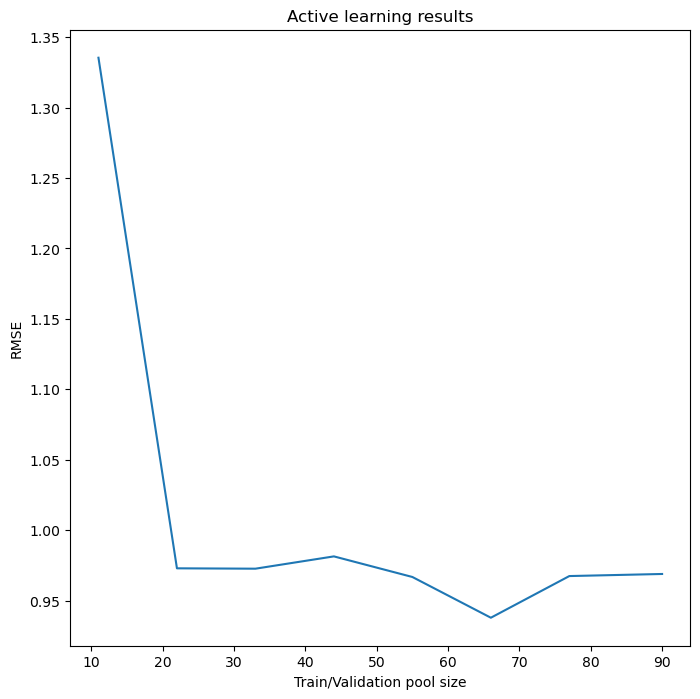

In [21]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Active learning results")
ax.set_xlabel('Train/Validation pool size'); ax.set_ylabel('RMSE')

ax.plot([a[0] for a in al_results], [a[1] for a in al_results])
plt.show()